## **空格觀點的 puzzle-based reshuffling**

### **集合**
---
$$
\begin{array}{ll}
   T & \text{時間集合，$T = \{1,2,3,...,|T|\}$}  \\
   N & \text{網格格點集合}  \\
   A & \text{格點間路徑集合}  \\
   R & \text{各類推盤集合，$R = \{0,1,2,...,|R|-1\}$}  \\
   \delta^{in}_{ri} & \text{推盤 $r\in R$ 流入格點 $i \in N$ 之節線集合， $\delta^{in}_{ri} \subset A$ } \\
   \delta^{out}_{ri} & \text{推盤 $r\in R$ 流出格點 $i \in N$ 之節線集合， $\delta^{out}_{ri} \subset A$ } \\
   P_{ij} & \text{虛擬推盤自格點 $i \in N$ 到格點 $j \in N$ 路徑中經過格點之集合， $P_{ij} \subset N$} \\
   C_{H_i} & \text{虛擬推盤移動路徑中經過格點 $i \in N$ 之水平節線集合， $C_{H_i} \subset A$} \\
   C_{V_i} & \text{虛擬推盤移動路徑中經過格點 $i \in N$ 之垂直節線集合， $C_{V_i} \subset A$} \\
   V_i & \text{虛擬推盤垂直進出格點 $i \in N$ 之節線集合， $V_i \subset A$ } \\
   H_i & \text{虛擬推盤水平進出格點 $i \in N$ 之節線集合， $H_i \subset A$ } \\
\end{array}\\
$$

### **參數**
---

$$
\begin{array}{ll}
   M & \text{極大懲罰數} \\
   \epsilon & \text{極小的數} \\
   S_i^r & \text{推盤 $r\in R$ 初始位置在格點 $i \in N$ 為1；反之為0} \\
   F_r & \text{出貨推盤 $r\in R \backslash \{0\}$ 的終點位置，$F_r \in N$} \\
   Num^r & \text{各類推盤 $r \in R$ 數量} \\
   |T| & \text{揀貨時間上限} \\
   |P_{ij}| & \text{虛擬推盤自格點 $i \in N$ 到格點 $j \in N$ 之路徑長度}
\end{array}\\
$$

### **變數**
---
$$
\begin{array}{ll}
   f^{tr}_{ij} & \text{推盤 $r\in R$ 在時刻 $t \in T$ 自格點 $i \in N$ 移至格點 $j \in N$ 為1；反之為0}  \\
   w & \text{出貨推盤盤送至揀貨點之最遲時刻，$w \in Integer^+$} \\
\end{array}\\
$$

In [27]:
from gurobipy import *

In [28]:
def print_dict(dict):
    print('{')
    for k, v in dict.items():
        print(f'\t{k}: {v}')
    print('}')
    
def print_2dlist(list):
    print('[')
    for row in list:
        print(f'\t{row}')
    print(']')

In [49]:
# import preprocess_spa
%run preprocess_spa.ipynb
# import output_spa
%run output_spa.ipynb

### **數學模式**
---
$$
\begin{array}{lll}
   Minimize & w + \epsilon *\displaystyle\sum_{t\in \{0\} \cup T} \displaystyle\sum_{(i,j) \in A, i \neq j} |P_{ij}| * f^{t0}_{ij}\\
   \\
   Subject \quad To & \\
   \\
   \textbf{流量守恆}\\
   \\
   選一條出去(或沒有) & \displaystyle\sum_{(i,j) \in \delta^{out}_{ri}} f_{ij}^{0r} = S^r_i & \forall  r \in R \\
   各類推盤守恆 & \displaystyle\sum_{i \in N} \displaystyle\sum_{(j,i) \in \delta^{in}_{ri}} f_{ji}^{|T|r} = Num^r & \forall r \in R \\
   前時刻進=現時刻出 & \displaystyle\sum_{(j,i) \in \delta^{in}_{ri}} f_{ji}^{(t-1)r} = \displaystyle\sum_{(i,j) \in \delta^{out}_{ri}} f_{ij}^{tr} & \forall i \in N ; t \in T ; r \in R \\
    \\
    \textbf{空格限制} \\
    \\
    同時同格點至多一位 & \displaystyle\sum_{r \in R} \displaystyle\sum_{(j,i) \in \delta^{in}_{ri}} f_{ji}^{tr} \leq 1 & \forall i \in N ; t \in \{0\} \cup T \\
    不允許空格區塊位移(移入移出擇一) & \displaystyle\sum_{(j,i) \in \delta^{in}_{0i}, i \neq j} f_{ji}^{t0} + \displaystyle\sum_{(i,j) \in \delta^{out}_{0i} } f_{ij}^{t0} \leq 1 & \forall i \in N ; t \in \{0\} \cup T \\
    出貨推盤移動路徑上要有空格 & \displaystyle\sum_{r \in R \backslash \{0\}} f_{ji}^{tr} \leq \displaystyle\sum_{(k,i) \in \delta^{in}_{0i}} \displaystyle\sum_{(k,l) \in \delta^{out}_{0k}, (i,j) \subset P_{kl}, k < min(i,l) } f_{kl}^{t0} & \forall i \in N ; (i,j) \in \delta^{out}_{r' i} , r' \in R \backslash \{0\} , i>j ; t\in \{0\} \cup T \\
    出貨推盤移動路徑上要有空格 & \displaystyle\sum_{r \in R \backslash \{0\}} f_{ji}^{tr} \leq \displaystyle\sum_{(k,i) \in \delta^{in}_{0i}} \displaystyle\sum_{(k,l) \in \delta^{out}_{0k}, (i,j) \subset P_{kl}, k > max(i,l) } f_{kl}^{t0} & \forall i \in N ; (i,j) \in \delta^{out}_{r' i} , r' \in R \backslash \{0\} , i<j ; t\in \{0\} \cup T \\
    空格移動路徑上的出貨推盤必定動 & \displaystyle\sum_{r \in R \backslash \{0\}} \displaystyle\sum_{k \in P_{ij}, k \neq j} f^{tr}_{kk} \leq M * (1 - f^{t0}_{ij}) & \forall i \in N ; (i,j) \in \delta^{out}_{0i} ; t \in \{0\} \cup T \\
    空格移動路徑上不存在其他空格重疊 & \displaystyle\sum_{k \in P_{ij}, k \neq j} \displaystyle\sum_{(k,l) \in \delta^{out}_{0k}, l \notin \{i,j\}} f^{t0}_{kl} + \displaystyle\sum_{k \in P_{ij}, k \neq j} \displaystyle\sum_{(l,k) \in \delta^{in}_{0k}, l \notin \{i,j,k\}} f^{t0}_{lk}\leq M * (1 - f^{t0}_{ij}) & \forall i \in N ; (i,j) \in \delta^{out}_{0i} ; t \in \{0\} \cup T \\
    空格不會垂直跨越 & \displaystyle\sum_{(k,l) \in C_i} f^{t0}_{kl} \leq 1 & \forall i \in N ; t \in \{0\} \cup T
    \\
    \textbf{轉向限制} \\
    \\
    實體貨物水平轉垂直 & \displaystyle\sum_{(i,j_1) \in H_i} f_{ij_1}^{(t-1)0} + \displaystyle\sum_{(k1,l1) \in C_i^H} f_{kl}^{(t-1)0} + \displaystyle\sum_{(j_2,i) \in V_i} f_{j_2i}^{t0} + \displaystyle\sum_{(k2,l2) \in C_i^V} f_{kl}^{t0} \leq 1 & \forall i \in N ; t \in T \\
    實體貨物垂直轉水平 & \displaystyle\sum_{(i,j_1) \in V_i} f_{ij_1}^{(t-1)0} + \displaystyle\sum_{(k1,l1) \in C_i^V} f_{kl}^{(t-1)0} + \displaystyle\sum_{(j_2,i) \in H_i} f_{j_2i}^{t0} + \displaystyle\sum_{(k2,l2) \in C_i^H} f_{kl}^{t0} \leq 1 & \forall i \in N ; t \in T \\
    \\
    \textbf{時間限制} \\
    \\
    紀錄進入終點時刻 & \displaystyle\sum_{(j, P_r) \in A, j \neq P_r} f^{tr}_{jP_r} \leq x^t_r & \forall t \in \{0\} \cup T ; r \in R \backslash \{0\} \\
    最遲抵達終點時刻 & (t+1) * x^t_r \leq w & \forall t \in \{0\} \cup T ; \forall r \in R \backslash \{0\} \\
    \\
    Bound & \\
          & f^{tr}_{ij} \in \{0,1\} & \forall r \in R ; (i,j) \in A ; t \in \{0\} \cup T \\
          & x^t_r \in \{0,1\} & \forall r \in R \backslash \{0\} ; t \in \{0\} \cup T\\
          & w \in Integer^+ \\
    \\
\end{array}\\            
$$

In [30]:
def runModelSpa(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, P_ij, Ci, Hi, Vi, I, P, S_ri, F_ri, M, epsilon, Num):

    model = Model("Puzzle-Based Reshuffling SPA")
    
    f = {}
    x = {}
    w = 0
    for t in [0]+T:
        for r in R:
            x[t,r] = model.addVar(vtype = "B", name = "x(%d,%d)" % (t,r))
            for i in N:
                for j in N:
                    f[t,r,i,j] = model.addVar(vtype = "B", name = "f(%d,%d,%d,%d)" % (t,r,i,j))
    
    w = model.addVar(vtype = "I", name = "w")
    
    for r in R:
        for i in N:
            # 時間 0，所有貨物 r 從起點出發遵守流量守恆
            model.addConstr(quicksum(f[0, r, i, j[1]] for j in Out_ri[r][i]) == S_ri[r][i], name = f"Start_R{r}_N{i}")
            # 所有相鄰時刻，同個點同個貨物要有一進一出
            if r != 0:
                model.addConstr(quicksum(f[T_ub, r, j[1], i] for j in In_ri[r][i]) == F_ri[r][i], name = f"End_R{r}_N{i}")
            for t in T:
                model.addConstr(quicksum(f[t-1, r, j[1], i] for j in In_ri[r][i]) == quicksum(f[t, r, i, j[1]] for j in Out_ri[r][i]),
                                name = f"Flow_balance_T{t}_R{r}_N{i}")
                
    # 時間 T，所有推盤類別 r 抵達終點，且同類推盤總和遵守流量守恆
    for r in R:
        model.addConstr(quicksum(f[T_ub, r, j[1], i] for i in N for j in In_ri[r][i]) == Num[r], name = f"End_R{r}")
                
    for t in [0]+T:
        for i in N:
            # 一格一托盤
            model.addConstr(quicksum(f[t, r, j[1], i] for r in R for j in In_ri[r][i] ) <= 1, 
                            name = f"Grid_{i}_Limit_in_time_{t}")
            # 不允許空格區塊位移
            model.addConstr(quicksum(f[t, 0, j[1], i] for j in In_ri[0][i] if j[1] != i) + 
                            quicksum(f[t, 0, i, j[1]] for j in Out_ri[0][i] if j[1] != i) <= 1, 
                            name = f"No_block_move_{i}_Limit_in_time_{t}")
            
            # 出貨推盤移動路徑上要有空格
            for j in Out_ri[1][i]:    # 不能是 [0][i]，我們要找實體路徑
                if i > j[1]:
                    model.addConstr(quicksum(f[t, r, i, j[1]] for r in R[1:]) <= \
                                    quicksum(f[t, 0, k[1], l[1]] for k in In_ri[0][i] for l in Out_ri[0][k[1]] \
                                             if i in P_ij[k[1]][l[1]] and j[1] in P_ij[l[1]][k[1]] and k[1] < l[1] and k[1] < i
                                            ), 
                                    name = f"Space_On_Route_T{t}_({i},{j[1]})")
                if i < j[1]:
                    model.addConstr(quicksum(f[t, r, i, j[1]] for r in R[1:]) <= \
                                    quicksum(f[t, 0, k[1], l[1]] for k in In_ri[0][i] for l in Out_ri[0][k[1]] \
                                             if i in P_ij[k[1]][l[1]] and j[1] in P_ij[l[1]][k[1]] and k[1] > l[1] and k[1] > i
                                            ), 
                                    name = f"Space_On_Route_T{t}_({i},{j[1]})")
    
            # 空格移動路徑上的出貨推盤必定動
            for j in Out_ri[0][i]:
                if i != j[1]:
                    if len(P_ij[i][j[1]]) != 1:
                        model.addConstr(quicksum(f[t, r, k, k] for k in P_ij[i][j[1]] if k != j[1] for r in R[1:]) 
                                        <= M * (1 - f[t, 0, i, j[1]]),
                                        name = f"Must_move_target_T{t}_({i},{j[1]})")
            # 空格移動路徑上不存在其他空格重疊
                        model.addConstr(quicksum(f[t, 0, k, l[1]] for k in P_ij[i][j[1]] if k != j[1] for l in Out_ri[0][k] if l[1] not in {i, j[1]}) + \
                                        quicksum(f[t, 0, l[1], k] for k in P_ij[i][j[1]] if k != j[1] for l in Out_ri[0][k] if l[1] not in {i, j[1], k}) \
                                        <= M * (1 - f[t, 0, i, j[1]]),
                                        name = f"No_cross_space_T{t}_({i},{j[1]})")
    
            # 空格不會垂直跨越
            if len(Ci[i]["Hori"]) > 0 and len(Ci[i]["Verti"]) > 0:
                model.addConstr(quicksum(f[t, 0, k, l] for (k,l) in Ci[i]["Hori"]) + quicksum(f[t, 0, k, l] for (k,l) in Ci[i]["Verti"]) <= 1,
                                name = f"No_cross_T{t}_N{i}")
    
    # 轉向限制
    for t in T:
        for i in N:
            # 轉向限制停留 1 單位時間
            model.addConstr(quicksum(f[t-1, 0, i, j1] for j1 in Hi[i]) + quicksum(f[t-1, 0, k, l] for (k,l) in Ci[i]["Hori"]) + \
                            quicksum(f[t, 0, j2, i] for j2 in Vi[i]) + quicksum(f[t, 0, k, l] for (k,l) in Ci[i]["Verti"]) <= 1,
                            name = f"H{i}_turn_V{i}")
            model.addConstr(quicksum(f[t-1, 0, i, j1] for j1 in Vi[i]) + quicksum(f[t-1, 0, k, l] for (k,l) in Ci[i]["Verti"]) + \
                            quicksum(f[t, 0, j2, i] for j2 in Hi[i]) + quicksum(f[t, 0, k, l] for (k,l) in Ci[i]["Hori"]) <= 1,
                            name = f"V{i}_turn_H{i}")

    # 紀錄推盤編號及抵達時間
    for t in [0]+T:
        for r in R[1:]:
            for endpos in P:
                if endpos[0] == r:
                    model.addConstr(quicksum(f[t, r, j[1], endpos[1]] for j in In_ri[r][endpos[1]] if j[1] != endpos[1]) <= 
                                    x[t, r] , name = f"Record_T{t}_R{r}")
    # 最遲時刻       
    for t in [0]+T:
        for r in R[1:]:
            model.addConstr( (t+1)*x[t,r] <= w, name = f"Time_Limit_R{r}")
    
    
    # for t in [0]+T:
    #     for r in R[1:]:
    #         for endpos in P:
    #             if endpos[0] == r:
    #                 model.addConstr(quicksum(f[t, r, endpos[1], j[1]] for j in Out_ri[r][endpos[1]]) >= x[t,r], name = f"Finish_T{t}_R{r}")
    
    
    is_running = False
    timelimit = 500
    model.Params.LogtoConsole = is_running  # 是否列出軟體求解過程
    model.Params.timeLimit = timelimit      # 求解時限
    model.setObjective(w + epsilon * quicksum(len(P_ij[i][j[1]]) * f[t, 0, i, j[1]] for t in [0]+T for i in N for j in In_ri[0][i]) , GRB.MINIMIZE)
    model.optimize()

    return model

def runAnalyzeModelSpa(model, map_start, size, T, R, A):
    if model.status == GRB.OPTIMAL:
        model.write("model_spa.lp")      # 可行約束條件
        # Print Optimal value and solution
        printModel(model, map_start, size, T, R, A)
        return model.Runtime, model.objVal
        
    elif model.status == GRB.TIME_LIMIT:    
        print("Time out, cannot get a optimal solution")
        print('-' * 40)
        return model.Params.timeLimit, 0
        
    elif model.status == GRB.INFEASIBLE:
        model.computeIIS()
        model.write("model_spa.ilp")   # 寫出不可行的約束條件
        print("Infeasible, no solution found.")
        print('-' * 40)
        return 0, 0


In [62]:
# 測試單一測資
# main test

size = (10,10)
n_sp = 99
n_tar = 1
id = 1

map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, P_ij, Ci, Hi, Vi, I, P, S_ri, F_ri, M, epsilon, Num = preprocess(size, n_sp, n_tar, id)
model = runModelSpa(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, P_ij, Ci, Hi, Vi, I, P, S_ri, F_ri, M, epsilon, Num)
runtime, obj = runAnalyzeModelSpa(model, map_start, size, T, R, A)
os.makedirs(f'result_graphform/model_spa/{size[0]}x{size[1]}/tar{n_tar}', exist_ok=True)
fp = f'result_graphform\\model_spa\\{size[0]}x{size[1]}\\tar{n_tar}\\graph_result_{size[0]}x{size[1]}_tar{n_tar}_sp{n_sp}_{id}.txt'
writeModel(model, map_start, fp, size, T, R, A)


GurobiError: Out of memory

In [37]:
# run all graphform
import csv
import os
import math

def writeResultCSV(size):
    s = size
    
    datadict, tar_list = pairDataDict(size)

    folder = 'result/model_spa'
    os.makedirs(folder, exist_ok=True)
    
    with open(f'result/model_spa/spa_{size[0]}x{size[1]}.csv', 'w') as f:
        w = csv.writer(f)
        w.writerow(['n_tar', 'n_sp', 'id', 'Runtime', 'Obj'])
        for n_tar, spacelist in datadict.items():
            os.makedirs(f'result_graphform/model_spa/{size[0]}x{size[1]}/tar{n_tar}', exist_ok=True)
            # 註：if 條件用來控制跑什麼測資
            for n_sp in spacelist:
                num = 10
                if s[0] == 3 and s[1] == 3:
                    if n_tar == 1 and n_sp == 8: num = 9
                    elif n_sp == 1: num = 9
                if s[0] >= 5: num = 5
                for id in range(num):    # 0~num-1
                    map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, P_ij, Ci, Hi, Vi, I, P, S_ri, F_ri, M, epsilon, Num = preprocess(size, n_sp, n_tar, id)
                    model = runModelSpa(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, P_ij, Ci, Hi, Vi, I, P, S_ri, F_ri, M, epsilon, Num)
                    runT, runObj = runAnalyzeModelSpa(model, map_start, size, T, R, A)
                    # 把個別結果寫到檔案
                    file_path = f'result_graphform\\model_spa\\{size[0]}x{size[1]}\\tar{n_tar}\\graph_result_{size[0]}x{size[1]}_tar{n_tar}_sp{n_sp}_{id}.txt'
                    writeModel(model, map_start, file_path, size, T, R, A)
                    # 記得處理 timeout 和 infeasible
                    w.writerow([n_tar, n_sp, id, round(runT, 3), runObj])
                # runT, runObj = runModelObs(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num)

In [58]:
# 這邊是引入 output_spa 來做
# main

size = (3,3)
datadict, tar_list = pairDataDict(size)
print(datadict)

{1: [2, 3, 4, 5, 6, 8], 2: [2, 3, 4, 5, 6, 7], 3: [2, 3, 4, 5, 6], 4: [2, 3, 4, 5], 5: [2, 3, 4], 6: [2, 3]}


In [56]:
# 這行是跑所有測資，會非常久（註：之後要考慮加上 os 來判斷檔案是否存在）
writeResultCSV(size)

running time =  5.634000062942505
optimal value =  9.022
----------------------------------------
running time =  0.28299999237060547
optimal value =  1.001
----------------------------------------
running time =  0.2990000247955322
optimal value =  1.001
----------------------------------------
running time =  4.547000169754028
optimal value =  9.02
----------------------------------------
running time =  2.6440000534057617
optimal value =  7.015
----------------------------------------
running time =  0.5689997673034668
optimal value =  5.008
----------------------------------------
running time =  1.5410001277923584
optimal value =  5.013
----------------------------------------
running time =  2.259999990463257
optimal value =  7.016
----------------------------------------
running time =  1.4079999923706055
optimal value =  5.014
----------------------------------------
running time =  0.2890000343322754
optimal value =  2.002
----------------------------------------
running time 

-----new_dict----
{
	1: {2: 0.14279999999999998, 3: 0.12469999999999999, 4: 0.0913, 5: 0.0728, 6: 0.07850000000000001, 8: 0.093}
	2: {2: 0.4452999999999999, 3: 0.35309999999999997, 4: 0.2165, 5: 0.17070000000000002, 6: 0.1356, 7: 0.16770000000000002}
	3: {2: 2.5186, 3: 0.46909999999999996, 4: 0.6936000000000001, 5: 0.44210000000000005, 6: 0.4434}
	4: {2: 4.5268999999999995, 3: 2.1498, 4: 1.5608, 5: 0.6798}
	5: {2: 9.1447, 3: 2.6839, 4: 2.5105}
	6: {2: 24.7409, 3: 9.529}
}


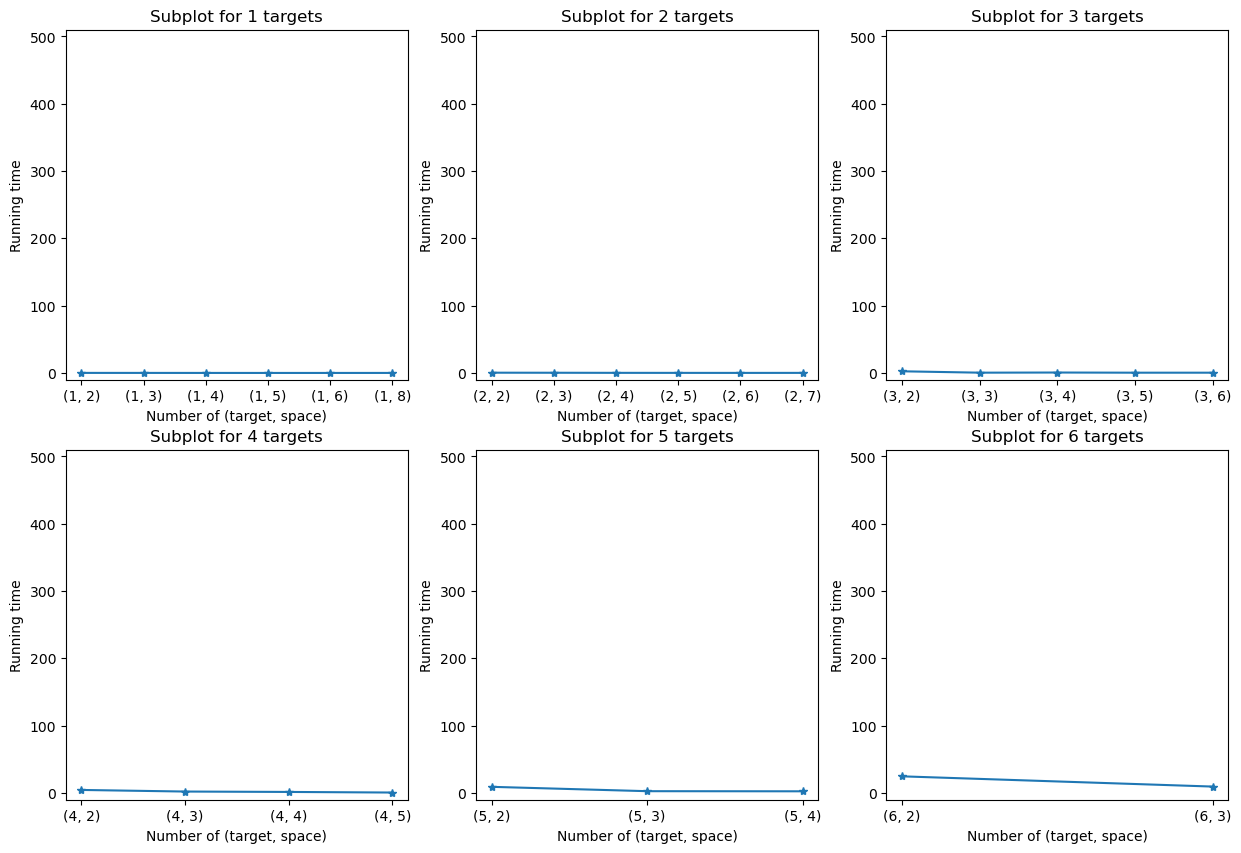

In [59]:
resultGraph(size, datadict, tar_list)

In [52]:
# 檢查結果

arr = []
for n_tar, spacelist in datadict.items():
    for n_sp in spacelist:
        num = 10
        if size[0] == 3 and size[1] == 3:
            if n_tar == 1 and n_sp == 8: num = 9
            elif n_sp == 1: num = 9
        if size[0] >= 4: num = 5
        for id in range(num):    # 0~num-1
            map_end = []
            result = []
            T_ub = 0
            with open(f"data_graphform\\{size[0]}x{size[1]}\\tar{n_tar}\\end\\graph_end_{size[0]}x{size[1]}_tar{n_tar}_sp{n_sp}_{id}.txt", "r") as file_end:
                T_ub = int(file_end.readline())
                for line in file_end.readlines():
                    map_end += [list(map(int, line.split(',')))]
            check = checkModel(model, T_ub, map_end, size, n_tar, n_sp, id)
            arr.append(check)
print(sum(arr))

259
